W tym ćwiczeniu dokonasz klasyfikacji obrazów ze zbioru danych **MNIST**. Jest to najbardziej powszechny zbiór danych, używany do klasyfikacji obrazów przy użyciu technologii Uczenia Maszynowego. 

Aby tego dokonać użyjesz biblioteki **Keras**, która w szybki sposób pozwoli zbudować sieć neuronową zdolną do dokonania takiej klasyfikacji z wysoką trafnością. 

Zbiór danych pochodzi ze strony: http://yann.lecun.com/exdb/mnist/. Składa się z dwóch mniejszych podzbiorów:
- treningowego (60000 obrazów czarno-białych o rozmiarze 28x28)
- testowego (10000 obrazów czarno-białych o rozmiarze 28x28)

Popularne zbiory danych używane w celach treningowych, są wbudowane w bibliotekę Keras, dzięki temu nie musimy sciągać danych z zewnątrz! 

Więcej na ten temat dostępne jest pod tym linkiem:

- https://keras.io/datasets/

## Wczytanie danych
Import obiektu ściagającego i wczytującego dane.

In [1]:
# Kontrola losowości - tyle trzeba się namocować aby zmusić Keras do powtarzalnych wyników :)
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras

Using TensorFlow backend.


Ściągniecie podzbiorów: treningowy/testowy oraz ich etykiet.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


## 1.0 Przygotowanie danych

#### Zadanie
Przekopiuj funkcję z poprzedniego ćwiczenia.

In [0]:
def preprocess_data_mlp(X_train, y_train, X_test, y_test, split_ratio, image_height, image_width):
    # Znormalizuj dane
    X_train_normalized = X_train / 255
    X_test_normalized = X_test / 255
    
    # Rozwiń obrazy do wektora
    X_train_reshaped = X_train_normalized.reshape(-1, image_height*image_width)
    X_test_reshaped = X_test_normalized.reshape(-1, image_height*image_width)
      
    # One-Hot Encoding
    y_train_ohe = keras.utils.to_categorical(y_train, len(set(y_train)))
    y_test_ohe =  keras.utils.to_categorical(y_test, len(set(y_test)))
    
    # Podziel dane na zbiory treningowy oraz walidacyjny
    split_index = int(X_train_reshaped.shape[0] * split_ratio)

    X_train_input = X_train_reshaped[:split_index]
    X_val_input = X_train_reshaped[split_index:]

    y_train_input = y_train_ohe[:split_index]
    y_val_input = y_train_ohe[split_index:]
    
    # Zapisz dane w dictionary
    data = {
        "X_train_input": X_train_input,
        "y_train_input": y_train_input,
        "X_val_input": X_val_input,
        "y_val_input": y_val_input,
        "X_test_input": X_test_reshaped,
        "y_test_input": y_test_ohe
    }
    
    return data

In [0]:
data = preprocess_data_mlp(X_train, y_train, X_test, y_test, 0.8, 28, 28)

### 2.0 Budowa i trenowanie sieci neuronowej typu MLP (Multi Layer Perceptron) w Keras

Pora na zbudowanie pierwszej sieci neuronowej. Dokonałem już za Ciebie importów podstawowych obiektów:
- **Sequential** - typ modelu
- **Dense** - podstawowy typ warstwy 
- **Activation** - pozwala na dokonanie aktywacji do uprzednio dodanej warstwy
- **Adam** - optimizer

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

#### Zadanie 1
Stwórz bardzo prostą sieć neuronową.
- wejście: 784 neurony (28x28) 
- warstwa ukryta: 1 neuron
- wyjście: 10 neuronów (ilość klas)

Aby tego dokonać użyj `Sequential` i zapisz w zmiennej `model`. Od tej pory możesz używać funkcji `.add(warstwa/aktywacja`), aby skonstruować swój model. Po każdej wartswie `Dense` powinna znaleźć się operacja `Activation` ustawiona na `relu` dla warstwy ukrytej oraz `softmax` dla warstwy wyjściowej.

In [0]:
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(784,)))
model.add(Dense(10, activation="softmax"))

#### Zadanie 2
Aby sprawdzić co znajduje się w zmiennej model wywołaj na nim `summary()`.

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


#### Zadanie 3
Skompiluj model używając na nim metody `.compile`. Funkcja ta przejmuje następujące parametry:
- **loss** - jest to string z nazwą funkcji, według której będzie obliczany błąd modelu podczas uczenia, użyj stringa *categorical_crossentropy* ponieważ zmagamy się z klasyfikacją typu multiclass (nie binarną)
- **optimizer** - obiekt optimizer, użyj *Adam()*, który dodatkowo przyjmuje opcjonalny parametr *learning_rate*
- **metrics** - lista stringów z nazwami metryk, jakie będą zwracane z procesu trenowania modelu, wstaw jednoelementową listę zawierającą string *accuracy*

`model.compile(parametr1=wartość1, parametr2=wartość2, ...)`

In [0]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.01),
              metrics=["accuracy"])

#### Zadanie 4

Trenowanie modelu. Wywołaj metodę `.fit` na obiekcie `model`. Api jest następujące:
    
    history = model.fit(dane_treningowe, etykiety_treningowe, batch_size=wartość, epochs=wartość,
                        validation_data(dane_walidacyjne, etykiety_walidacyjne))
    
gdzie:
- **batch_size** - fragment danych, podawanych do sieci neuronowej w jednej iteracji treningowej, np. 256 próbek
- **epoka** - jedna epoka mija kiedy do sieci podczas treningu zostanie podane tyle batchy by pokryć cały zbiór (jeżeli mamy 25600 próbek a batch_size to 256 to epoka mija po 100 iteracjach)
- **history** - to słownik, w którym zapisane zostaną zadeklarowane metryki modelu podczas każdej epoki (np. accuracy, error value)

In [35]:
data.keys()

dict_keys(['X_train_input', 'y_train_input', 'X_val_input', 'y_val_input', 'X_test_input', 'y_test_input'])

In [36]:
history = model.fit(data["X_train_input"], data["y_train_input"],
                    batch_size=1024, epochs=30,
                    validation_data=(data["X_val_input"], data["y_val_input"]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 2s 39us/step - loss: 0.4019 - acc: 0.8751 - val_loss: 0.1708 - val_acc: 0.9486
Epoch 2/30
48000/48000 [==============================] - 2s 35us/step - loss: 0.1327 - acc: 0.9601 - val_loss: 0.1183 - val_acc: 0.9652
Epoch 3/30
48000/48000 [==============================] - 2s 34us/step - loss: 0.0855 - acc: 0.9741 - val_loss: 0.1014 - val_acc: 0.9697
Epoch 4/30
48000/48000 [==============================] - 2s 33us/step - loss: 0.0594 - acc: 0.9826 - val_loss: 0.0949 - val_acc: 0.9708
Epoch 5/30
48000/48000 [==============================] - 2s 34us/step - loss: 0.0429 - acc: 0.9870 - val_loss: 0.0890 - val_acc: 0.9740
Epoch 6/30
48000/48000 [==============================] - 2s 34us/step - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0920 - val_acc: 0.9739
Epoch 7/30
48000/48000 [==============================] - 2s 34us/step - loss: 0.0251 - acc: 0.9929 - val_loss: 0.0854 - val_acc

#### Zadanie 5
Kolejnym krokiem jest wyświetlenie finalnych metryk, pokazujących jak model się sprawuje po procesie uczenia.

Aby tego dokonać ma zmiennej `model` wywołaj metodę `.evaluate`. Api jest następujące:

    result = model.evaluate(dane_które_model_ma_sklasyfikować, oczekiwane_wartości)
    
gdzie:
- **result** - to tuple zawierającyc rezultaty dla podanych danych danych

Wykonaj `.evaluate` dla danych treningowych, walidacyjnych oraz testowych, aby wyświetlić metryki dla każdego zbioru.

In [37]:
train_score = model.evaluate(data["X_train_input"], data["y_train_input"])
val_score = model.evaluate(data["X_val_input"], data["y_val_input"])
test_score = model.evaluate(data["X_test_input"], data["y_test_input"])

10000/10000 [==============================] - 0s 42us/step


In [38]:
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.00020189366936938314
 - acc: 1.0
Validation data results:
 - error: 0.09636947269533357
 - acc: 0.9805
Test data results:
 - error: 0.08189333970706784
 - acc: 0.9813


#### Krzywe uczenia
Poniższy kod wykorzystuje zwrócony przez metodę `.fit` obiekt `history` aby wyświetlić zmieniający się błąd modelu w czasie (co epokę).

In [39]:
history.history["loss"]

[0.40186049207051594,
 0.13274145915110905,
 0.08545991973082225,
 0.05941774235169093,
 0.04286857541402181,
 0.03349173498153687,
 0.025071454842885334,
 0.018728052551547688,
 0.015092720232903957,
 0.011694253855695327,
 0.009346461867292722,
 0.006211813487112522,
 0.005320974241321286,
 0.0032556770679851373,
 0.0029057606300339103,
 0.0018413883180667956,
 0.0010813041923878094,
 0.0006712619246294101,
 0.0005318024396741142,
 0.0004729872092915078,
 0.00041822957643307743,
 0.0003836541175066183,
 0.00035155728373986977,
 0.0003311118755955249,
 0.00030186620028689506,
 0.0002839208615090077,
 0.0002640614959721764,
 0.00024709271057508887,
 0.00023155999350516745,
 0.0002202207901670287]

In [40]:
history.history["val_loss"]

[0.17080928428967793,
 0.11829259133338928,
 0.10137321416536967,
 0.0948836616675059,
 0.08900913234551748,
 0.09196608344713847,
 0.08539959212144216,
 0.08535156679153443,
 0.09375000274181366,
 0.08826127767562866,
 0.08998261805375417,
 0.08698042380809784,
 0.0903870191971461,
 0.0881622136036555,
 0.09017551267147064,
 0.09072450761000316,
 0.08810105562210083,
 0.09109744127591451,
 0.09106509665648142,
 0.09172815863291423,
 0.09247293214003245,
 0.09285328189531962,
 0.09329673922061921,
 0.09373669278621674,
 0.09470627880096436,
 0.09459282318751017,
 0.0947891134818395,
 0.09573934924602509,
 0.0959390463034312,
 0.09636944552262625]

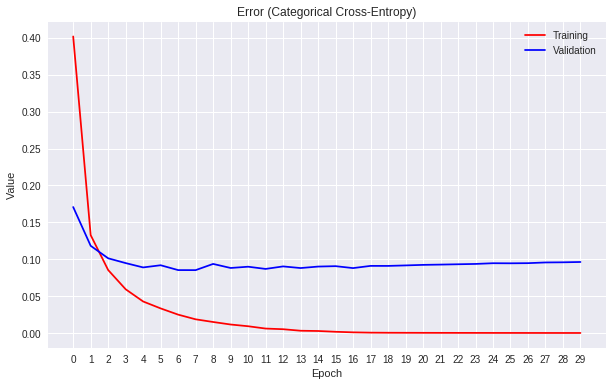

In [41]:
import matplotlib.pyplot as plt

# Stworzenie figury
f, ax = plt.subplots()

# Modyfikacja kształtu figury 
f.set_size_inches(10, 6)
    
# Narysowanie krzywej błędu dla danych treningowych (czerwona)
ax.plot(history.history["loss"], c="r")

# Narysowanie krzywej błędu dla danych walidacyjnych (niebieska)
ax.plot(history.history["val_loss"], c="b")

# Opisanie figury
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.set_xticks(range(0, len(history.history["loss"])))
ax.legend(["Training", "Validation"], loc="best");

#### Zadanie 6
Napisz własną funkcję, która zestawia powyższe operacje. Niech funkcja ta przyjmuje nastepujące parametry:
- data - dictionary zawierające dane z funkcji `preprocess_data_mlp`,
- model - stworzony model poprzez wywołanie `Sequential()` wypełniony odpowiednimi warstwami/operacjami Keras,
- opcjonalne parametry do edycji takie jak `learning_rate`, `batch_size` `epochs`.

In [0]:
def run_model(data, model, learning_rate=0.01, batch_size=1024, epochs=20):
    
    # Skompiluj model, podmień parametr optymalizatora z liczby na learning_rate
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
    
    # Trenowanie modelu przy pomocy .fit, zparametryzuj batch_size oraz epochs
    history = model.fit(data["X_train_input"], data["y_train_input"], batch_size=batch_size, epochs=epochs,
                    validation_data=(data["X_val_input"], data["y_val_input"]))
    
    # Ewaluacja modelu dla zbiorów train, val, test 
    train_score = model.evaluate(data["X_train_input"], data["y_train_input"], verbose=0)
    val_score = model.evaluate(data["X_val_input"], data["y_val_input"], verbose=0)
    test_score = model.evaluate(data["X_test_input"], data["y_test_input"], verbose=0)

    # Wyświetlenie metryk
    train_score, train_accuracy = train_score
    print("\nTrain data results:")
    print(" - error: {}".format(train_score))
    print(" - acc: {}".format(train_accuracy))

    val_score, val_accuracy = val_score
    print("Validation data results:")
    print(" - error: {}".format(val_score))
    print(" - acc: {}".format(val_accuracy))

    test_score, test_accuracy = test_score
    print("Test data results:")
    print(" - error: {}".format(test_score))
    print(" - acc: {}".format(test_accuracy))
    
    # Kod wyświetlania krzyw uczenia
    f, ax = plt.subplots()
    f.set_size_inches(10, 6)

    ax.plot(history.history["loss"], c="r")
    ax.plot(history.history["val_loss"], c="b")
    ax.set_title("Error (Categorical Cross-Entropy)")
    ax.set_ylabel("Value")
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(0, len(history.history["loss"])))
    ax.legend(["Training", "Validation"], loc="best");

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 15us/step - loss: 2.3016 - acc: 0.1108 - val_loss: 2.3022 - val_acc: 0.1060
Epoch 2/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 3/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3014 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 4/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 5/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 6/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3022 - val_acc: 0.1060
Epoch 7/20
48000/48000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3019 - val_acc

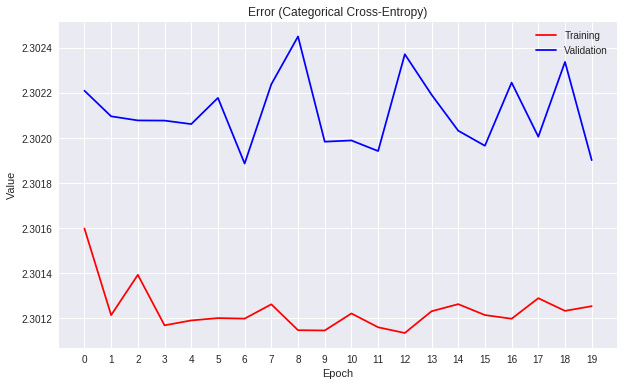

In [21]:
model = Sequential()

model.add(Dense(1, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

run_model(data, model, learning_rate=0.01, batch_size=1024, epochs=20)

### 7.0 Eksperymentowanie z architerkturą
Spróbujmy teraz zobaczyć jak modyfikowanie architektury modelu wpływa na wynik. Sprawdź następujące architektury.

1. Jedna warstwa ukryta z 56 neuronami, aktywacja relu
2. Jedna warstwa ukryta z 128 neuronami, aktywacja relu
3. Jedna warstwa ukryta z 256 neuronami, aktywacja relu
4. Dwie warstwy ukryte odpowiedni z 256(relu)/256(relu) neuronami

In [0]:
model_1 = # miejsce na Twój kod

# miejsce na Twój kod

In [0]:
model_2 = # miejsce na Twój kod

# miejsce na Twój kod

In [0]:
model_3 = # miejsce na Twój kod

# miejsce na Twój kod

In [0]:
model_4 = # miejsce na Twój kod

# miejsce na Twój kod

W perceptronie wielowarstwowym wiele warstw nie zawsze działa lepiej. Rzadko kiedy używa się więcej niż trzech warstw ukrytych.

### 8.0 Ostateczny model
Spróbuj zbudować samodzielnie inne **3 inne modele**. Poeksperymentuj z hiperparametrami. Spróbuj pobić wynik najlepszego modelu. 

In [0]:
# miejsce na Twój kod